In [2]:
from binance.client import Client

client = Client()

klines = client.get_historical_klines("ETHUSDT", Client.KLINE_INTERVAL_1HOUR, "6 months ago UTC")

In [3]:
import pandas as pd
import pandas_ta as ta
import numpy as np

df = pd.DataFrame(klines, columns = ["open_time", "open", "high", "low", "close", "vol", "close_time", "quote_vol", \
                                    "trades", "taker_base_vol", "taker_quote_vol", "ignore"])

df = df[["open_time","open", "high", "low", "close"]]

df["open_time"] = pd.to_datetime(df["open_time"], unit="ms")

df["open"] = df.open.astype(float)
df["high"] = df.high.astype(float)
df["low"] = df.low.astype(float)
df["close"] = df.close.astype(float)

## take the rolling atr so the yaxis doesn't shake too much
df["atr"] = ta.atr(high=df.high, low=df.low, close=df.close)
df["atr"] = df.atr.rolling(window=30).mean()

df.set_index("open_time", inplace=True)
df

,open,high,low,close,atr
open_time,,,,,
2022-09-22 10:00:00,1292.12,1302.75,1288.00,1295.72,NaN
2022-09-22 11:00:00,1295.73,1313.02,1288.88,1308.50,NaN
2022-09-22 12:00:00,1308.51,1313.70,1302.50,1307.11,NaN
2022-09-22 13:00:00,1307.12,1308.15,1270.20,1271.78,NaN
2022-09-22 14:00:00,1271.78,1286.35,1263.50,1266.32,NaN
...,...,...,...,...,...
2023-03-22 05:00:00,1801.18,1807.66,1800.87,1803.65,18.990224
2023-03-22 06:00:00,1803.65,1804.18,1796.19,1798.45,18.843898
2023-03-22 07:00:00,1798.45,1798.58,1787.15,1792.75,18.697453


In [4]:
%matplotlib inline

import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from scipy.signal import savgol_filter
from scipy.signal import find_peaks
from IPython import display
from IPython.display import HTML
pd.set_option("mode.chained_assignment", None)

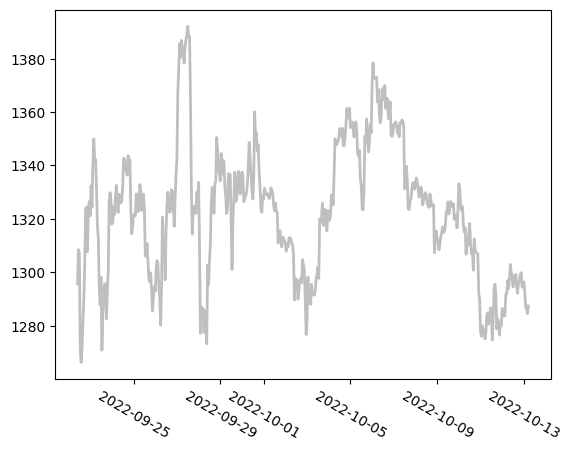

In [5]:
df2 = df.iloc[0:500]

fig, ax = plt.subplots()

plt.xticks(rotation=-30)

price, = ax.plot(df2.index, df2.close, c="grey", lw=2, alpha=0.5, zorder=5)

plt.show()

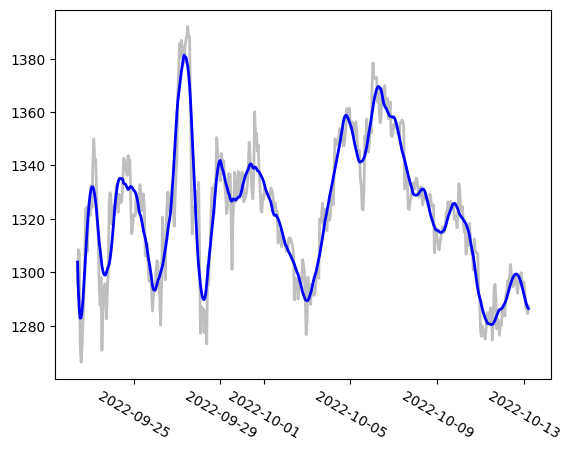

In [6]:
df2 = df.iloc[0:500]

df2["close_smooth"] = savgol_filter(df2.close, 49, 5)

fig, ax = plt.subplots()
plt.xticks(rotation=-30)
price, = ax.plot(df2.index, df2.close, c="grey", lw=2, alpha=0.5, zorder=5)
price_smooth, = ax.plot(df2.index, df2.close_smooth, c="b", lw=2, zorder=5) 

plt.show()

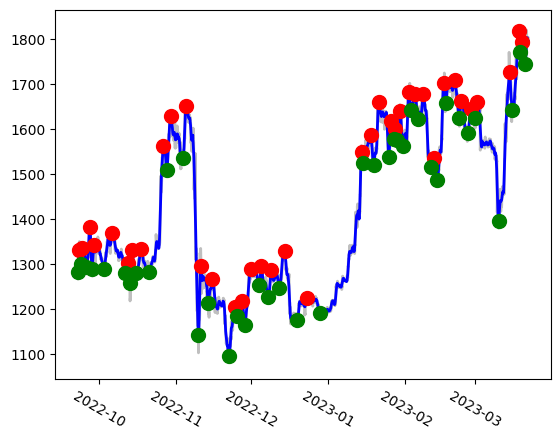

In [7]:
# df2 = df.iloc[0:500]
df2 = df

df2["close_smooth"] = savgol_filter(df2.close, 49, 5)

fig, ax = plt.subplots()
plt.xticks(rotation=-30)
price, = ax.plot(df2.index, df2.close, c="grey", lw=2, alpha=0.5, zorder=5)
price_smooth, = ax.plot(df2.index, df2.close_smooth, c="b", lw=2, zorder=5) 

atr = df2.atr.iloc[-1]

peaks_idx, _ = find_peaks(df2.close_smooth, distance=15, width=3, prominence=atr)
troughs_idx, _ = find_peaks(-1*df2.close_smooth, distance=15, width=3, prominence=atr)

peaks, = ax.plot(df2.index[peaks_idx], df2.close_smooth.iloc[peaks_idx], \
                c="r", linestyle="None", markersize=10.0, marker="o", zorder=10)

thoughs, = ax.plot(df2.index[troughs_idx], df2.close_smooth.iloc[troughs_idx], \
                c="g", linestyle="None", markersize=10.0, marker="o", zorder=10)

plt.show()

In [8]:
peaks_idx, _ = find_peaks(df2.close_smooth, distance=15, width=3, prominence=atr)
troughs_idx, _ = find_peaks(-1*df2.close_smooth, distance=15, width=3, prominence=atr)

print(peaks_idx)
print(troughs_idx)


[  16   47  118  158  333  488  525  613  825  897 1046 1185 1299 1513
 1585 1674 1771 1867 1995 2208 2736 2826 2902 3022 3062 3110 3192 3252
 3332 3429 3528 3632 3697 3788 3847 4163 4248 4280]
[   3   30   85  140  254  458  505  568  691  860 1018 1165 1259 1460
 1536 1612 1749 1835 1942 2118 2336 2748 2851 2999 3045 3078 3133 3213
 3279 3402 3467 3549 3675 3760 3825 4055 4189 4265 4311]


In [10]:
# Create a new column in the DataFrame called "position"
df2['long_short_position'] = 0

# Set position values based on long and short signals
# df2['long_short_position'] = np.zeros(len(df))
df2['long_short_position'].iloc[peaks_idx] = 1
df2['long_short_position'].iloc[troughs_idx] = -1

# Adjust the position column to hold the most recent position until there is a signal to go in the other direction
prev_pos = 0
for i in range(len(df)):
    if df2['long_short_position'][i] != 0:
        prev_pos = df2['long_short_position'][i]
    else:
        df2['long_short_position'][i] = prev_pos

# df2 = df2.drop(['position', 'LongShortPosition'], axis = 1)

df2[25:55]

,open,high,low,close,atr,close_smooth,long_short_position
open_time,,,,,,,
2022-09-23 11:00:00,1294.68,1297.27,1282.14,1287.74,NaN,1308.654456,1
2022-09-23 12:00:00,1287.75,1305.62,1285.56,1298.18,NaN,1305.565334,1
2022-09-23 13:00:00,1298.19,1319.13,1267.77,1270.87,NaN,1302.461003,1
2022-09-23 14:00:00,1270.86,1288.74,1262.15,1283.68,NaN,1300.612009,1
2022-09-23 15:00:00,1283.68,1309.09,1277.57,1293.94,NaN,1299.466231,1
2022-09-23 16:00:00,1293.95,1298.67,1277.81,1295.45,NaN,1298.957144,-1
2022-09-23 17:00:00,1295.44,1302.49,1283.55,1295.79,NaN,1298.999980,-1
2022-09-23 18:00:00,1295.80,1307.42,1277.12,1282.61,NaN,1299.929371,-1
2022-09-23 19:00:00,1282.62,1296.09,1274.32,1292.26,NaN,1301.142209,-1


In [11]:
import backtesting

df2 = df2.rename(columns={"open": "Open", "close": "Close", "low": "Low", "high": "High"})

class MyStrategy(backtesting.Strategy):
    
    stop_loss_percent = 15
    last_purchase_price = 0
    long_hold = 0
    short_hold = 0
    i = 0
    
    def init(self):
        super().init()
        
    def next(self):
        super().init()

        self.i += 1

        long_entry_signals = 0
        long_exit_signals = 0
        short_entry_signals = 0
        short_exit_signals = 0


        print(self.data.long_short_position)
        
        
    
        # If long_short_position is 1, go long
        if self.data.long_short_position == 1:
            long_entry_signals += 1
            short_exit_signals += 1
        # If long_short_position is -1, go short
        if self.data.long_short_position == -1:
            long_exit_signals += 1
            short_entry_signals += 1
      
        #  Stop loss
        price = self.data.df['close_smooth'][-1]
        if price <= self.last_purchase_price * (1 - self.stop_loss_percent/100):
            long_exit_signals += 1

        if price >= self.last_purchase_price * (1 + self.stop_loss_percent/100):
            short_exit_signals += 1

        #  LONG
        #--------------------------------------------------
        if self.long_hold == 0 and long_entry_signals >= 1:
            #  Buy
            self.long_hold = 1
            self.position.close()
            self.buy()
            self.last_purchase_price = price

        elif self.long_hold == 1 and long_exit_signals >= 1:
            # Close any existing long trades, and sell the asset
            self.long_hold = 0
            self.position.close()
            self.last_purchase_price = 0

        #  SHORT
        #--------------------------------------------------
        if self.short_hold == 0 and short_entry_signals >= 1:
            #  Sell
            self.short_hold = 1
            self.position.close()
            self.sell()
            self.last_purchase_price = price

        elif self.short_hold == 1 and short_exit_signals >= 1:
            # Close any existing long trades, and sell the asset
            self.short_hold = 0
            self.position.close()
            self.last_purchase_price = 0
            
# Backtest the strategy
bt = backtesting.Backtest(df2, MyStrategy, cash=10000, commission=0.002)
results = bt.run()

# Print the results
print(results)

[0 0]


ValueError: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().